SWOT_KaRIn_MIT_Cal/Val_Vesrsion1

Short Name:
SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1

Collection Concept ID:
C2147947806-POCLOUD

https://podaac.jpl.nasa.gov/dataset/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1?ids&values&search=swot%20simulated%20level-2&provider=POCLOUD

In [65]:
import s3fs
import os
import os.path
import json
import warnings
import requests
import numpy as np
import pandas as pd
import xarray as xr
from io import StringIO

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

# import geoviews as gv
# import hvplot.xarray
# import holoviews as hv
# gv.extension('bokeh', 'matplotlib')

warnings.filterwarnings("ignore")

# %matplotlib inline
# %matplotlib qt5
%matplotlib widget

## Set some parameters (start/end time)

In [66]:
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 400

savefig = True # set to true to save plots as file
!mkdir ../plots

__figdir__ = '../plots/'
savefig_args = {'bbox_inches':'tight', 'pad_inches':0.2}
plotfiletype='png'

mkdir: cannot create directory ‘../plots’: File exists


## PO DAAC Catalog exploration using the CMR API

- The search is restricted to colections that have data over a given time window

In [67]:
provider = 'POCLOUD'
url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 500,
                            'temporal': ['2021-10-01T10:00:00Z','2021-11-01T00:00:00Z'] 
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
response.headers['cmr-hits']

'246'

### Loop through each response in the catalog and print the respective concept ID

These are the data sets that cover the time period of interest

In [68]:
#  This will show short names and concept ids for all PO.DAAC data sets at this time
if False:
    for r in response.json()['items']:
        print('{} ==> '.format(r['meta']['s3-links'][0].split('/')[1]), r['meta']['concept-id'])

### Loading credentials for direct access

In [69]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

In [70]:
# Center location
#site = 'S-MODE'
site = 'S-MODE IOP1'
#site = 'SPURS-1'

if site == 'S-MODE':
    lon0 = -123.5
    lat0 = 37.5 
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'S-MODE IOP1':
    lon0 = -124.5
    lat0 = 37
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -125
    lat0 = 10
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-1':
    lon0 = -38
    lat0 = 25
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat

# Define the max/min lon
lon_min = lon0 - dlon
lon_max = lon0 + dlon
lat_min = lat0 - dlat
lat_max = lat0 + dlat

In [71]:
'''# Define the max/min lon
lon_min = 0
lon_max = 360
lat_min = -90
lat_max = 90
'''

'# Define the max/min lon\nlon_min = 0\nlon_max = 360\nlat_min = -90\nlat_max = 90\n'

In [72]:
start_time = '2011-11-13T00:00:00Z'
end_time = '2012-11-12T00:00:00Z'

In [73]:
'''url = 'https://cmr.earthdata.nasa.gov/search/granules'

concept_id = 'C2152046451-POCLOUD'; shortname= 'SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_CALVAL_V1'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': start_time+','+end_time,
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 500,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])'''

"url = 'https://cmr.earthdata.nasa.gov/search/granules'\n\nconcept_id = 'C2152046451-POCLOUD'; shortname= 'SWOT_SIMULATED_L2_KARIN_SSH_GLORYS_CALVAL_V1'\nresponse = requests.get(url, \n                        params={\n                            'concept_id': concept_id,\n                            'temporal': start_time+','+end_time,\n                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    \n                            'page_size': 500,\n                            },\n                        headers={\n                            'Accept': 'application/json'\n                            }\n                       )\nprint(response)\nprint(response.headers['CMR-Hits'])"

In [74]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

# VIIRS_NPP-OSPO-L2P-v2.61 ==>  C1996880725-POCLOUD

concept_id = 'C2147947806-POCLOUD'; shortname= 'SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1'
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': start_time+','+end_time,
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 500,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
736


In [75]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][1]['href'])
# granules_url
len(granules_url)
print('Number of files found is ' + str(len(granules_url)))
if len(granules_url) == 500:
    print('Max number of files returned. There may be more files.  Try shortening time window.')

Number of files found is 500
Max number of files returned. There may be more files.  Try shortening time window.


In [76]:
gran['links']#['rel'=='http://esipfed.org/ns/fedsearch/1.1/s3#'];

[{'rel': 'http://esipfed.org/ns/fedsearch/1.1/data#',
  'title': 'Download SWOT_L2_LR_SSH_Expert_250_002_20120717T095511_20120717T104617_DG10_01.nc',
  'hreflang': 'en-US',
  'href': 'https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_250_002_20120717T095511_20120717T104617_DG10_01.nc'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
  'title': 'This link provides direct download access via S3 to the granule',
  'hreflang': 'en-US',
  'href': 's3://podaac-ops-cumulus-protected/SWOT_SIMULATED_L2_KARIN_SSH_ECCO_LLC4320_CALVAL_V1/SWOT_L2_LR_SSH_Expert_250_002_20120717T095511_20120717T104617_DG10_01.nc'},
 {'rel': 'http://esipfed.org/ns/fedsearch/1.1/metadata#',
  'title': 'api endpoint to retrieve temporary credentials valid for same-region direct s3 access',
  'hreflang': 'en-US',
  'href': 'https://archive.podaac.earthdata.nasa.gov/s3credentials'},
 {'rel': 'http://esipfed.org/ns/fedsearch/

In [77]:
# This loads a single file
ds = xr.open_dataset(fs.open(granules_url[1]))

In [78]:
ds

<xarray.Dataset>
Dimensions:                                (num_lines: 9868, num_pixels: 71,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 ...
    longitude                              (num_lines, num_pixels) float64 ...
    latitude_nadir                         (num_lines) float64 ...
    longitude_nadir                        (num_lines) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/92)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ssh_karin_2                            (num_lines, num_pixels) float64 ...
    ...                                     ...
    simulated_error_karin                  (num_lines, num_pixels) float64 ...
    simulated_error_timing                 (num_lines, num_pixels) float64 ...
    simulated_error_roll                   (num_lines, num_pixels) float64 ...
    simulated_error_phase                  (num_lines, num_pixels) float64 ...
    simulated_error_orbital                (num_lines, num_pixels) float64 ...
    simulated_error_troposphere            (num_lines, num_pixels) float64 ...
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-23 07:44:27Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       311.89957599684425
    right_last_latitude:        77.03365811434979
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.0033528106647474805

In [79]:
np.squeeze(ds)

<xarray.Dataset>
Dimensions:                                (num_lines: 9868, num_pixels: 71,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 ...
    longitude                              (num_lines, num_pixels) float64 ...
    latitude_nadir                         (num_lines) float64 ...
    longitude_nadir                        (num_lines) float64 ...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/92)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ssh_karin_2                            (num_lines, num_pixels) float64 ...
    ...                                     ...
    simulated_error_karin                  (num_lines, num_pixels) float64 ...
    simulated_error_timing                 (num_lines, num_pixels) float64 ...
    simulated_error_roll                   (num_lines, num_pixels) float64 ...
    simulated_error_phase                  (num_lines, num_pixels) float64 ...
    simulated_error_orbital                (num_lines, num_pixels) float64 ...
    simulated_error_troposphere            (num_lines, num_pixels) float64 ...
Attributes: (12/32)
    Conventions:                CF-1.7
    title:                      Level 2 Low Rate Sea Surface Height Data Prod...
    institution:                CNES/JPL
    source:                     Simulate product
    history:                    2021-09-23 07:44:27Z : Creation
    platform:                   SWOT
    ...                         ...
    right_last_longitude:       311.89957599684425
    right_last_latitude:        77.03365811434979
    wavelength:                 0.008385803020979
    orbit_solution:             POE
    ellipsoid_semi_major_axis:  6378137.0
    ellipsoid_flattening:       0.0033528106647474805

In [80]:
file_list =  [fs.open(file) for file in granules_url]

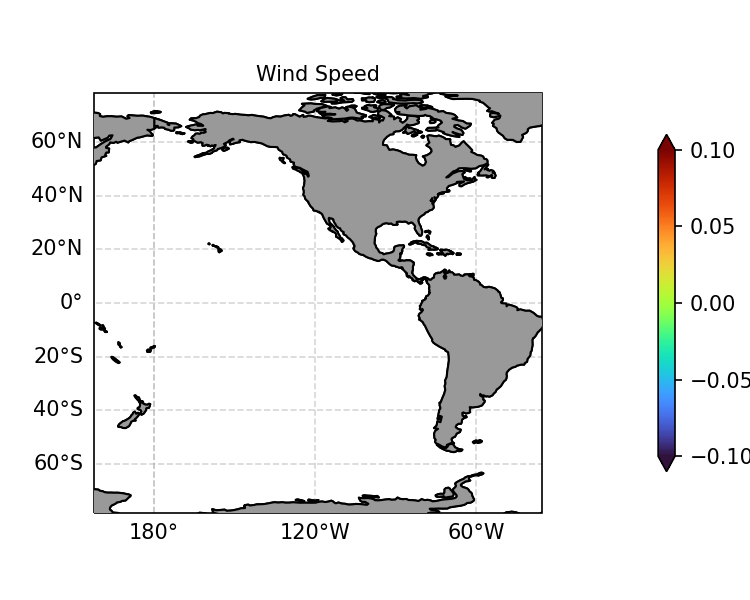

In [81]:
plt.figure(1)
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
#ax.set_extent(extent, crs=ccrs.PlateCarree())


plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Wind Speed', size = 10.)

ds = xr.open_dataset(file_list[10])
var = ds.wind_speed_model_u #simulated_true_ssh_karin
#plt.pcolor(ds.longitude, ds.latitude, var)
cs = ax.pcolormesh(ds.longitude,ds.latitude,var,transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.029,pad = 0.2,extend='both')
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
#cs = ax.pcolormesh(ds.longitude,ds.latitude,ds.sea_surface_temperature.squeeze()-274.15,vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
#cb = plt.colorbar(cs,fraction = 0.022,extend='both')
#cb.set_label('SST [$\circ$C]',fontsize = 10)

In [92]:
ds = xr.open_mfdataset(file_list, chunks='auto')

NotImplementedError: Can not use auto rechunking with object dtype. We are unable to estimate the size in bytes of object data

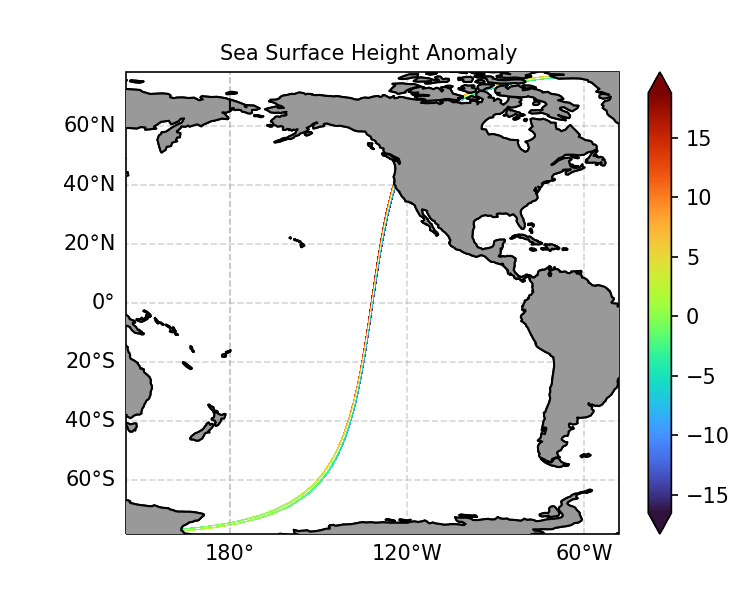

In [82]:
plt.figure(2)
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
#ax.set_extent(extent, crs=ccrs.PlateCarree())


plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Sea Surface Height Anomaly ', size = 10.)

ds = xr.open_dataset(file_list[1])
var = ds.ssha_karin_2 #simulated_true_ssh_karin
#plt.pcolor(ds.longitude, ds.latitude, var)
cs = ax.pcolormesh(ds.longitude,ds.latitude,var,transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.046,extend='both')
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
#cs = ax.pcolormesh(ds.longitude,ds.latitude,ds.sea_surface_temperature.squeeze()-274.15,vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
#cb = plt.colorbar(cs,fraction = 0.022,extend='both')
#cb.set_label('SST [$\circ$C]',fontsize = 10)

In [89]:
plt.figure(3)
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
#ax.set_extent(extent, crs=ccrs.PlateCarree())


plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('Sea Surface Height Anomaly ', size = 10.)

ds = xr.open_dataset(file_list[2])
var = ds.ssha_karin #simulated_true_ssh_karin
#plt.pcolor(ds.longitude, ds.latitude, var)
cs = ax.pcolormesh(ds.longitude,ds.latitude,var,transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.046,extend='both')
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
#cs = ax.pcolormesh(ds.longitude,ds.latitude,ds.sea_surface_temperature.squeeze()-274.15,vmin=V[0],vmax=V[1],transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
#cb = plt.colorbar(cs,fraction = 0.022,extend='both')
#cb.set_label('SST [$\circ$C]',fontsize = 10)

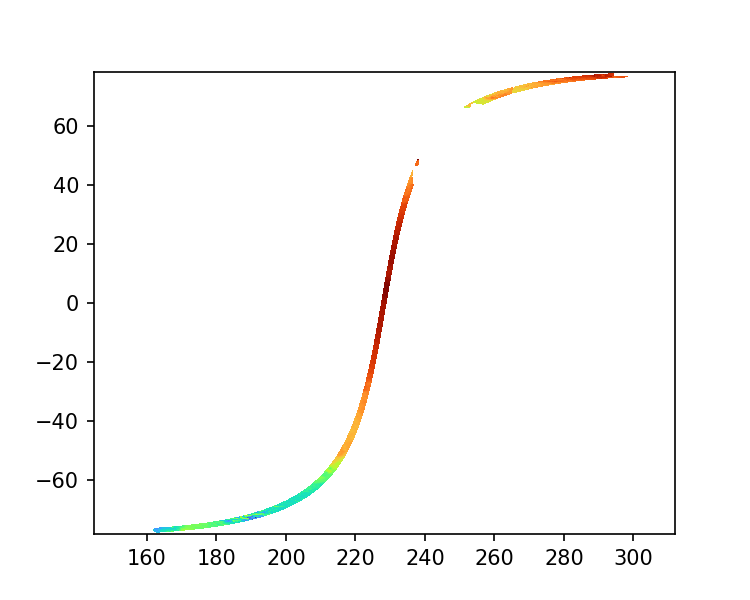

In [84]:
var = ds.simulated_true_ssh_karin #ssha_karin_2 #simulated_true_ssh_karin

plt.figure(4)
plt.pcolor(ds.longitude, ds.latitude, var)

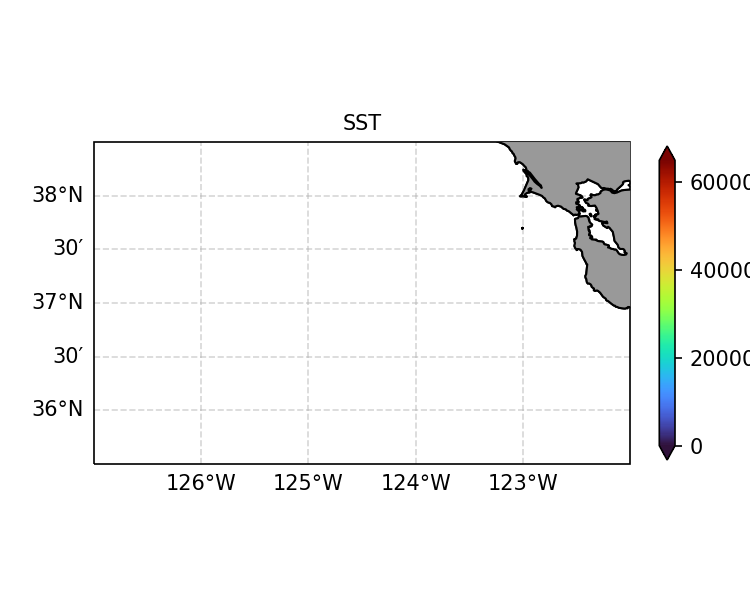

In [85]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())

var1 = ds.wind_speed_karin
plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('SST', size = 10.)

# Does not do what I think it should:
#ax.minorticks_on()
#ax.tick_params(axis='both',which='both',direction='inout',top=True, right=True)

V=np.array([0,65000])
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
cs = ax.pcolormesh(ds.longitude,ds.latitude,var1,vmin=V[0],vmax=V[1])
cb = plt.colorbar(cs,fraction = 0.027,extend='both')
cb.set_label('Wind Speed [m/s]',fontsize = 10)


In [86]:
ds = xr.open_dataset(file_list[1])

In [87]:
ds.latitude.plot()
#ds = xr.open_dataset(file_list[0]).sel(longitude=slice(lon_min2,lon_max2), latitude=slice(lat_min,lat_max))

In [88]:
lon_min2=lon_min+360
lon_max2=lon_max+360